# Exploratory Data Analysis

## English language Wikipedia, diversity by content size

This notebook is used for exploratory data analysis of token count, vocabulary size, and lexical diversity by content length in UTF-8 encoded bytes.  Token count is defined as the response from the NLTK word_tokenize function.  Vocabulary size is defined as the case-sensitive count of unique alphabetic word tokens with different casing defined as different words.  Lexical diversity is defined as the ratio of case-sensitive unique tokens relative to the total content token count.

The data were prepared by pulling 1000 random English language Wikipedia articles as serialized JSON data with the Wikipedia API, culling to a total of 645 articles by removing all stub articles (defined as an exclusion criterion in this study), and cleaning the content text with the `clean` function in this notebook.

Execution requires unpacking of the `data` archive in this directory.

In [1]:

import json
from pathlib import Path
import re

from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
from nltk import FreqDist
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.util import bigrams
import numpy as np
import pandas as pd
from scipy import stats

jsondir = Path("data")
json_list = jsondir.glob("*.json")

REF_RE = re.compile(r"\[\d{1,3}\]")


def utf8len(s):
    return len(s.encode('utf-8'))


def clean(text):
    # remove "[edit]" strings that are used for content editing
    cleaned_content = text.replace("[edit]", "")
    # remove "[\d]" style reference strings
    cleaned_content = re.sub(REF_RE, "", cleaned_content)
    # remove "[citation neeeded]" editorial strings
    cleaned_content = cleaned_content.replace("[citation needed]", "")

    return cleaned_content

def get_vocab_size(content):
    vocab_list = set(token for token in content if token.isalpha())
    return len(vocab_list)

def get_lexical_diversity(content):
    """Returns a case-sensitive lexical diversity measure.  We want to keep case forms
    of the same word as these are considered different tokens in this corpus."""
    return len(set(content)) / len(content)

lexical_diversity_list = []
vocab_size_list = []
content_size_list = []
tokens_count_list = []
file_list = []

for json_file in json_list:
    content_list = []
    is_a_stub = False
    with open(json_file, "r") as f:
        json_obj = json.loads(f.read())
        html_text = json_obj["parse"]["text"]
        soup = BeautifulSoup(html_text, "lxml")
        # get text
        contents = soup.find_all("p")
        for content in contents:
            cleaned_content = clean(content.text)
            content_list.append(cleaned_content)
        
        full_str = "\n".join(content_list)
        content_size = utf8len(full_str)
        tokens = word_tokenize(full_str)
        lex_div = get_lexical_diversity(tokens)
        vocab_size = get_vocab_size(tokens)

        file_list.append(f"{json_file}")
        content_size_list.append(content_size)
        lexical_diversity_list.append(lex_div)
        vocab_size_list.append(vocab_size)
        tokens_count_list.append(len(tokens))


print(len(content_size_list))
print(len(tokens_count_list))
print(len(lexical_diversity_list))
print(len(vocab_size_list))

645
645
645
645


In [2]:
ldf = pd.DataFrame(
    {'title': file_list, 
     'tokens': tokens_count_list,
     'lexical_diversity': lexical_diversity_list,
     'vocabulary_size': vocab_size_list,
     'content_size': content_size_list
})

ldf.sort_values(by='tokens', ascending=False).head(25)

,title,tokens,lexical_diversity,vocabulary_size,content_size
423,data/37857.json,11597,0.244546,2628,66871
194,data/58632868.json,11518,0.111738,903,56265
397,data/10725.json,7810,0.275416,1966,43976
383,data/29489398.json,5472,0.186038,967,19056
564,data/1168437.json,5355,0.267787,1140,27317
399,data/683374.json,5332,0.308515,1428,31667
259,data/21312310.json,5268,0.203493,1009,30742
414,data/236714.json,5125,0.293463,1347,27701
595,data/55371870.json,5113,0.283395,1401,27119
140,data/34985138.json,4746,0.235356,1043,24863


In [3]:
print(f"Content size median: {np.median(ldf['content_size'])} bytes")
print(f"IQR: {stats.iqr(ldf['content_size'])}\n\n")
print(f"Token count median: {np.median(ldf['tokens'])}")
print(f"IQR: {stats.iqr(ldf['tokens'])}\n\n")
print(f"Vocabulary count median: {np.median(ldf['vocabulary_size'])}")
print(f"IQR: {stats.iqr(ldf['vocabulary_size'])}\n\n")
print(f"Lexical diversity median: {np.median(ldf['lexical_diversity']):.2f}")
print(f"IQR: {stats.iqr(ldf['lexical_diversity']):.2f}\n\n")

Content size median: 1867.0 bytes
IQR: 3188.0


Token count median: 353.0
IQR: 599.0


Vocabulary count median: 151.0
IQR: 213.0


Lexical diversity median: 0.51
IQR: 0.22




In [4]:
ldf.corr(method="pearson")

,tokens,lexical_diversity,vocabulary_size,content_size
tokens,1.000000,-0.550653,0.925923,0.994942
lexical_diversity,-0.550653,1.000000,-0.634252,-0.546781
vocabulary_size,0.925923,-0.634252,1.000000,0.936872
content_size,0.994942,-0.546781,0.936872,1.000000


Text(0, 0.5, 'Tokens')

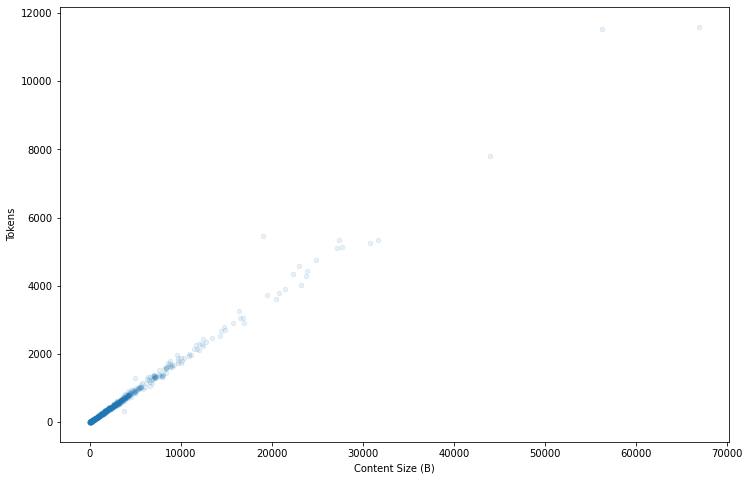

In [5]:
plt.rcParams['figure.figsize'] = [12, 8]

ax = ldf.plot(kind="scatter", x="content_size", y="tokens", alpha=0.1)
ax.set_xlabel("Content Size (B)")
ax.set_ylabel("Tokens")

Text(0, 0.5, 'Vocabulary Size')

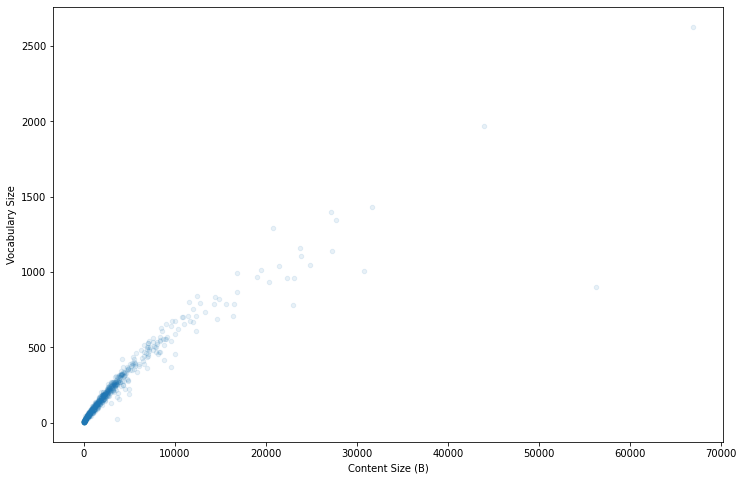

In [6]:
ax = ldf.plot(kind="scatter", x="content_size", y="vocabulary_size", alpha=0.1)
ax.set_xlabel("Content Size (B)")
ax.set_ylabel("Vocabulary Size")

Text(0, 0.5, 'Lexical Diversity')

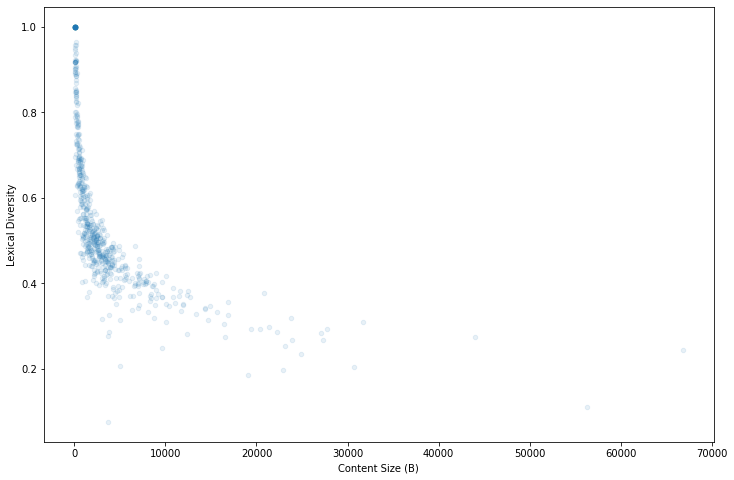

In [8]:
ax = ldf.plot(kind="scatter", x="content_size", y="lexical_diversity", alpha=0.1)
ax.set_xlabel("Content Size (B)")
ax.set_ylabel("Lexical Diversity")